# Project Description

The "IEEE-CIS Fraud Detection" competition was organised by the IEEE Computational Intelligence Sosiecty (IEEE-CIS) as it sought to improve the already existing fraud detection system that too often incorrectly flags legit transactions as fraudulent. This project sought to address this by building a machine learning model that would accurately predict the probability that an online card transaction is fraudulent.

## Data

In this project, the model will be predicting the probability that an online transaction is fraudulent, denoted by the binary target feature "isFraud". 

The data for this project is real-world e-commerce transaction data provided by leading payment service company, Vesta Corporation. The data is broken into two files : "identity" and "transaction" which are joined by the "TransactionID" column. Not all transactions have corresponding information in the identity file.

There are train and test sets for both the "identity" and "transaction" files.

## How will the models be evaluated?

The models will be evaluated on area under the ROC curve between the predicted probability and the observed target.

## What does the data look like?

Aside from the structure of the data files, little is known about the data. To find out more about what the data is like, we will do some data exploration.

# Data Exploration

## Prepare the Environment 

I will load the packages needed for the data exploration as well as all the packages needed for this sumary notebook.

In [ ]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

import gc

## Load Training Data 

I will begin by loading the training data and check the size of the training files

In [ ]:
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')

print(f'Size of train_id - rows: {train_id.shape[0]}, columns: {train_id.shape[1]}')
print(f'Size of train_transaction - rows:{train_transaction.shape[0]}, columns: {train_transaction.shape[1]}')

The train sets appear to be very large. The "identity" train file has over 144,000 observations and 41 features, and the "transaction" train file has over  590,500 files with over 390 features.  

###  Look at the files more closely

Now, I will look at the first few observations of the train "identity" file

In [ ]:
train_id.head()

Even though we can't see all 41 features, we now have a slighty better idea what features are in the train "identity" file.

Let's look at all the columns names in the train_id file.

In [ ]:
train_id.columns

Next, I will look at the first few observations of the train "transaction" file

In [ ]:
train_transaction.head()

Again, we can only see a few of the over 390 columns that make up the train transaction file. 

We can look at the complete list of column names in the transaction_id file

In [ ]:
train_transaction.columns.values.tolist()

## Merge Dataframes 

We now have two separate training files : "train_id" and "train_transaction". To make them easier to work with, we will join these files into one. As mentioned earlier, the two files have the "TransaactionID" feature/column in common.

We will also look at the size of this merged dataframe.

In [ ]:
train = train_transaction.merge(train_id,on=['TransactionID'],how='left') 
print(f'Size of train - rows : {train.shape[0]}, columns : {train.shape[1]}')

Our new dataframe named "train" has 590,540 observations and 434 features.This is a large file to work with. 

Let's look at how much storage space it is taking up 

In [ ]:
train = train_transaction.merge(train_id,on=['TransactionID'],how='left') 
print(f'Size of train - rows : {train.shape[0]}, columns : {train.shape[1]}')

The new mergeed dataframe named "train" is large and has 590,540 observations and 434 features. 

Let's see how much space it is taking up.

In [ ]:
train_GB = train.memory_usage(deep = True).sum()/1024**3 
print(f'train dataframe is using {train_GB:.2f} GB of memory storage')

### Challenge 1 : Disk Space Usage 

This brings me to my first challenge in the project. The dataframe is using up a lot of memory already. Running any analysis with this notebook would lead to notebook shutting down due to it using more disk space than available. 

The solution to this challenge is to reduce size of notebook and how much disk space it takes up.

## Memory Optimization

One way to reduce notebook size is to delete unused files. 

We will be using the merged train dataframe moving forward and no longer have use for the train_id and train_transaction dataframes. I will drop these to free up some memory

In [ ]:
del train_id
del train_transaction
gc.collect

Any way to reduce memory usage is to change datatypes for columns so that they are taking up minimum space based on their size

In [ ]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

train = reduce_mem_usage(train)

## Missing Data

Let's take a look at a small section of our train dataframe

In [ ]:
train.head

### Challenge 2 : High Amounts of Missing Data

By looking at only 5 observations, I can see a bunch of features with "NaN" values which indicate missing features.

Let's see how much missing values we have in each column of our dataframe.

In [ ]:
total_mv= train.isnull().sum().to_frame()                        #round to whole number 
percent_mv = (train.isnull().sum()/train.isnull().count()*100)   # round to 2 dp

pd.concat([total_mv, percent_mv], axis=1, keys=['Total Missing Values', 'Percent']).transpose()

Many machine learning alogrithms do not support missing values and so we will have to find a method to address this. This will be discussed in other notebooks.

## Label Distribution

Our target feature "isFraud" is a binary feature with values "0" and "1",  with 0  indicating a valid transaction and 1 indiicating a fraudulent transaction.

Let's look at the distribution of this feature.

In [ ]:
target_count = train['isFraud'].value_counts()
target_percent = train['isFraud'].value_counts()/len(train)

print('Target Column : isFraud')
pd.concat([ target_count, target_percent], axis=1, keys=['Count', 'Percent'])

Let's look at a visualization of the label. 

In [ ]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

In [ ]:
plot_count('isFraud',  'train: isFraud', df=train, size=1)

### Challenge 3: Unbalanced Data  

The chart above shows that our label column is heavily unbalanced with 96.5% being valid transactions and 3.5% being fraudulent.

Depending on what machine learning algorithm we use, we may need to find a method to address the imbalance in the label feature. 

Next, we will look at the distribution of other features in the dataframe. 

Let's start by looking at the feature "card6" which tells the type of card used in the transaction. It has the values "debit", "credit", "debit or credit" and "charge card". 

In [ ]:
plot_count('card6',  'train: card6', df=train, size=2)

We can see that most of the values in the "card6" column fall under "debit". 

This [notebook](http://www.kaggle.com/code/arababudu/aba-ieee-cis-eda) shows the distribution of some more features and provides more information on what each feature stands for.

# Correlation Study (Numerical Features Only)

We saw earlier that our dataset is extremely large. To make it easier to work, we decided to only focus on the numeric features and then introduce the categorical features once we had a better idea of what models will be most suited for data. Dealing with numeric data is often easier than categorical data given that we do not have to deal with additional complexities such as having our already large dataset become even bigger with additional features once one-hot endoding is done, especially as some catgeorical features have several levels.

To separate the categorical and numerical features, we first have to identify which is which and then drop the categorical features form the dataframe.

In [ ]:
cat_features = ['ProductCD', 'card1','card2','card3','card4','card5','card6', 'addr1','addr2', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13','id_14','id_15',
                'id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30','id_31',
                'id_32','id_33','id_34','id_35','id_36','id_37','id_38']

num_features = [x for x in train.columns.values[2:] if x not in cat_features]  #slicing from 2 onwards ( first 2 columns are identifier and target)

features = num_features + cat_features

print('Categorical features :', len(cat_features))
print('Numerical features : ',len(num_features))

In [ ]:
train.drop(cat_features, axis=1, inplace=True)

print(train.shape)

Even after dropping the categorical features, we still have 385 numerical features to work with. 

This is still a large number of features to work with. To be able to cut down more on the numebr of features, we decided to look at how closely correlated the numerical features are to each other and drop the ones that are highly correlated ad likely to be redundant in our models. 

## Address Missing Values : Imputation 

Before doing the correlation study, we have to address  the issue of missing values. 

With a lot of the features have high number of missing values, deleting columns with missing values could have led to deleting info that could be vitalto our study. For that reason, we dediced to create animputer that imputes the mean of the column in the palce of the missing values 

In [ ]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(train)
X_train = imputer.transform(train)
print(X_train.shape)

Using the Pearson method, I found the correlation coefficient between the features. The correlation coefficients have values between -1 to 1 with a  value closer to 0 implying weaker correlation (exact 0 implying no correlation), a value closer to 1 implying stronger positive correlation, and a value closer to -1 implying stronger negative correlation. 

Columns with high correlation (>0.95) were filtered out, leading to a smaller dataframe with 188 columsn as compared to 385 in the original dataframe with only numeric features. 

This new dataframe was saved for potential future use. 

Details of the correlation tudy can be found in this [notebook](http://www.kaggle.com/code/arababudu/aba-ieee-cis-correlation-study-numeric) .


# Models Considered

It is no secret that we have a complex dataset to work with. For this reason, we decided to start exploring the data using tree models. Even though tree models have the potenital to overfit training data to models, they tend to be more effective in decribing relationships incomplex models than linear models. 

To begin our analysis of the dataset, we chose a [decision tree model and a random forest model](http://www.kaggle.com/code/arababudu/aba-ieee-cis-dt-rf).

Even though we performed some imputation and feature selection(by looking at correlation between features)  earlier, these tree models will allow us to use our raw data without any of those adjustments. Tree models are also not affected by unbalanced data, making them ideal for our dataset. 

It is important to note that we are still only using numerical features. 

## Decision Tree Model 

 I performed hyperparameter tuning using **GridSearch** and came up with a decision model with the following parameters :
  - Max depth : *16*
  - Minimum Sample Leaf : *16* 
  
 The model had a cross-validation score of ***0.8194899985974899*** and a training accuracy of **0.977745791986995** 

## Random Forest Model 

I performed hyperparameter tuning using **GridSearch** and came up with the random forest with the following parameters :
 - Max depth : *32*
 - Minimum Sample Leaf : *8* 
 
The model had a cross-validation score of ***0.8929305137464629*** and a training accuracy of **0.9784146713177769** 

Of the two models, the random forest model appaered to be working better. It was selected as my final model and trained for submission to the competition. 

My [submission](http://www.kaggle.com/code/arababudu/aba-ieee-cis-submission) yeilded a score of **0.697474 (Public)/0.657028 (Private).**

# Hyperparameter Tuning Using Optuna

Equipped with the knowledge that tree-based models are best for working with the kind of data for this project, I decided to look at more tree-based models in addition to decision trees and random forests models, but also look beyond GridSearch. 

Optuna is a hyperparameter optimization software that helps to speed up optimization time and performance as compared to traditional methods like GridSearch. It also allows visualization of optimization histories to provide a better understanding of the model. 

Optuna is able to handle missing data and so there is no need to perform mean imputation when using  performing hyperparameter tuning using Optuna.It can also handle categorical features without having to perform any encoding. 


## Decision Tree Using Optuna  

Using Optuna, I found the [best decision tree model](http://www.kaggle.com/code/arababudu/aba-ieee-cis-dt-optuna) to have a training accuracy of **0.841120941451202** and the following parameters : {'max_depth': *32*, 'min_samples_leaf': *63}*

I [trained the model](http://www.kaggle.com/code/arababudu/aba-ieee-cis-dt-optuna-best-model-training) and [submitted](http://www.kaggle.com/code/arababudu/aba-ieee-cis-dt-optuna-best-model-submission) to the competition, yielding a score of **0.698641** (Public)/**0.662993** (Private)

## Random Forest Using Optuna  

Using Optuna, I found the [best random forest  model](http://www.kaggle.com/code/arababudu/aba-ieee-cis-rf-optuna) to have a training accuracy of **0.8937299686276652** and the following parameters
{'n_estimators': *149*, 'max_depth': *143*, 'min_inst': *7*}

I [trained the model](http://www.kaggle.com/code/arababudu/aba-ieee-cis-rf-optuna-best-model-training) and [submitted](http://www.kaggle.com/code/arababudu/aba-ieee-cis-rf-optuna-best-model-submission) to the competition, yielding a score of **0.879880** (Public)/**0.868998** (Private)

## LightGBM Using Optuna 

Using Optuna, I found the [best lightGBM  model](http:www.kaggle.com/code/arababudu/aba-ieee-cis-lgbm-optuna) to have a training accuracy of **0.9046651355907586** and the following parameters :
{'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.1818283932263683, 'subsample': 0.7161639451557493, 'boosting_type': 'gbdt'}

I [trained the model](http://www.kaggle.com/code/arababudu/aba-ieee-cis-lgbm-optuna-best-model-training) and [submitted](http://www.kaggle.com/code/arababudu/aba-ieee-cis-lgbm-optuna-best-model-submission) to the competition, yielding a score of **0.0.879511** (Public)/**0.854963** (Private)

## Other Tree Models Considered - Optuna  

I had performed hyperparameter tuning on an extra random forest model and a gradient boosted tree model using Optuna. I, however, did not move forward with these models as I had decided to go with a lightGBM model for myfinal model.

Below are the best parameters I obtained for the models:

-[Extra Random Forest](http://www.kaggle.com/code/arababudu/aba-ieee-cis-ert-optuna) - Training Accuracy : **0.8723944989366234**

Best parameters : {'n_estimators': 198, 'max_depth': 24, 'min_inst': 1, 'features': 10, 'criterion': 'entropy'}

- [Gradient Boosted Trees](http://www.kaggle.com/code/arababudu/aba-ieee-cis-gbt-optuna) - Training ACcuracy : **0.9144679636483682**

Best parameters : {'n_estimators': 149, 'learning_rate': 0.14137079907030553, 'gamma': 4.9855153794046245, 'subsample': 0.8824143100313434, 'max_depth': 26}

### Moving Forward 

Even though my random forest model performed had a higher score than my lightGBM model, I decided to go with lightGBM as myfinal model becasue it had  abetter training accuracy, and mainly because othr people who had submitted to the same competition had better results with that over random forest models.

# Feature Engineering and Feature Selection

## Reintroduce Categorical Features  

All the analysis done up to this point have only included the numerical features. Having decided on using LightGBM as the model model, it was time to reintroduce the categorical features in our analysis. 

### LGBM Model using ALL Features  

Using [all the features (numerical and categorical)](https://www.kaggle.com/code/arababudu/aba-ieee-cis-lgbm-optuna-all-features), I performed hyperparameter tuning to obtain the best parameters for an LGBM model. 

I obtained a training accuracy of **0.9373617375337107** and the following best parameters: 
{'n_estimators': 120, 'max_depth': 38, 'num_leaves': 239, 'learning_rate': 0.12789669760962175, 'subsample': 0.9150948533665225, 'n_jobs': 2, 'boosting_type': 'goss'}

That model yield an AUC score of **0.930258**(Public) /**0.897167**(Private).

## Encoding New Features

Taking inspiration from some Kaggle discussions and notebooks, I [encoded new features](https://www.kaggle.com/code/arababudu/ieee-fraud-feature-engineering) from the existing features to be used in my model. 36 new features were generated. Some of the newly encoded features are described below:

- LogTransactionAmt : Log of trnasaction amount 
- Transaction_day_of_week : Day of week in which transaction occurred 
- Transaction_hour_of_day : Hour of day in which transaction occurred 

## Feature Selection 

#### Useful_Features + All New Features 

Again, taking inspiration from some Kaggle discussions and notebooks, I was able to extract 279 out of the original 432 (originally 434 but minus ID and label columns) features which I named "Useful_features". These are the only old features I will be using in my model moving forward. 

Using all my useful features plus newly engineered features, I trained a [LGBM model with parameters obtained by Optuna](http://www.kaggle.com/code/arababudu/ieee-fraud-feature-engineering) ({'n_estimators': 201, 'num_leaves': 137, 'reg_alpha': 4.943363340834117e-05, 'subsample': 0.961542728984385, 'colsample_bytree': 0.6851318248279135, 'max_depth': 35, 'learning_rate': 0.1860689937955665}). I recieved an AUC score of **0.915896**(Public) /**0.882711**(Private). 

I trained a [second model](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-all) using the same set of features but different hyperparameters : {'n_estimators': 156, 'num_leaves': 291, 'reg_alpha': 0.2123250553775631, 'subsample': 0.77807857574779, 'colsample_bytree': 0.43010083540262456, 'max_depth': 17, 'learning_rate': 0.11502632449363365}, and recieved a private score of **0.905069**.

#### Useful_Features + New Time Features  

Next, I trained an LGBM model using [all my old useful features plus only the new time features](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-time) (ie. Transaction_day_of_week,Transaction_hour_of_day, Transaction_hour, and TransactionAmt_decimal). I obtained a private AUC score of **0.900459**.

The model appears to be correctly predicting the prabability that a transaction is fraudulent about 90% of the time. While this is a good score,w e would like to see if the model can be made to perform better. 

#### New Time Features Only  

Seeing that my new time features seem to be improving the model's performance(as their addition to the useful features led to an improved score), I decided to train a model using [just those new time features](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-time-only). The model obtained a private score of **0.707526**.

This is an indication that the new time features are not that great by themselves.

#### New LogTransactionAmt Feature Only 

The next LGBM model I trained used [only the new LogTransactionAmt feature](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-logamt-only). It yelded a private score of 0**.664564**. 

#### Old TransactionAmt Feature Only  

My next model trained on [only the old TransactionAmt feature](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-tramt-only) and obtained a private score of **0.676786**.

#### Old TransactionAmt + New LogTransactionAmt. 

The [TransactionAmt and LogTransactionAmt features](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-tramt-logamt) do not do so great on their own but could they be powerful together? I trained a model using just those two features and obtained a score of **0.679293**. 

These two features together so not seem to improve model performance. 

#### Useful_Features + LogTransactionAmt

My next model used all the [old useful_features plus the new logTransactionAmt feature](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-logamt). The model obtained a private AUC score of **0.902784**. It appears that even though the new LogTransactionAmt feature does not do so well by itself, it improves model performance when paired with the useful old features. 

#### 10 New Features Only 

Taking inspiration from Dr Beane, I trained a model using [10 new features He had found to be relevant](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-x-only) to his model  to see the impact they had on the model. The 10 features are LogTransactionAmt, 3 uid features, 4 time fatures and 2 proton_check features. I used these new features without any adding any old features. The model obtained a private AUC score of **0.784455**. 

#### Old Useful_Features + 10 New Features  

The w0 new features mentioned above do not seem to do so well on their own but does pairing them with the old features help? To find out, I trained a model using the [old useful_features + the 10 new features ](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-x)and obtained a score of **0.898499**.

The 10 new features appear to improve model performance when paired with the old useful features rather than by themselves.

## Further Feature Selection Using Feature Importance 

So far, our best model has been the model trained on all the old useful features and all the new features, mkaing a total of 315 features. This is down from the original 432 features but still a large amoutn fo features to work with. 

Our goal for the next part of the project is to try to achieve the same or better model performance with fewer features. Fewer features will improve model training time and reduce the amount of computational resources needed to train the model. 

Idecided to look at feature importance and use that as a criteria to eliminate features from the model. 

### Drop 20 features with the least importance  

for my next model, I took the bets performing model so far (with all old useful_features and all new features) and generated the feature importance for the columns. Then I dropped the 20 columns with the least feature imprtance and trained a new model based on [my new dataset with 20 fewer features](https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-eng-imp-drop-bottom-20). That model yielded a score of **0.896603**, indicating that the dropped features did not help to improve mdoel performance. 

### Drop 40 features with least importance 

I went ahead to generate feature importance for the features used in my last model as dropped features could cause other features which had lesser importance at first to become importnace. I dropped 20 more features with the least importance, mkaing 40 so far and trained a model based on the rest of the fetaures left. The model obtained a score of 0.**896915**.

This is a slight improvement from the last model where 20 mfeatures were dropped but still had a performace that fell below the model with all the old useful features features + new features. 

# Final Model 

Based on AUC scores, the best model derived so far is the model with the old 279 useful features Plsu the new 36 features. This model ontained a score of **0.905069**. Ideally, we would like the final model to have fewer features than 315 but with the time we had for this project, this was the best model obtained.

## Model Performance

To further evaluate the performance of our final model, we used [cross validation prediction](https://www.kaggle.com/arababudu/aba-ieee-cis-final-model-performance) to generate out-of-sample predictions for our model. This was carried out by first generating synthetic data comprising of 30,000 observations and 315 features. Then the final model was trained on this new data. 


#### Out-Of-Sample Accuracy 

The out-of-sample accuracy score for the model was 0.9366

#### Precision and Recall  

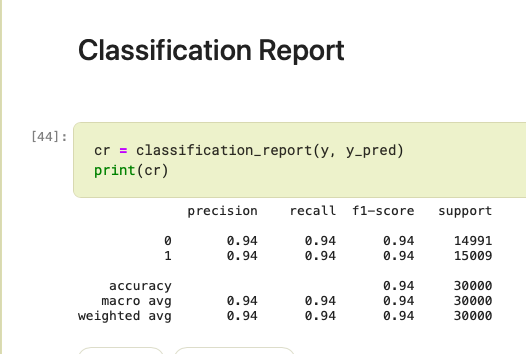

The precision score for the model is 0.94. This means that when the model predicts that a transaction is fraudulent, it is correct 94% of the time.   

Recall for the model is 0.94, indicating that the model corretly identifies 94% of all fraudulent transactions. 

#### Confusion Matrix

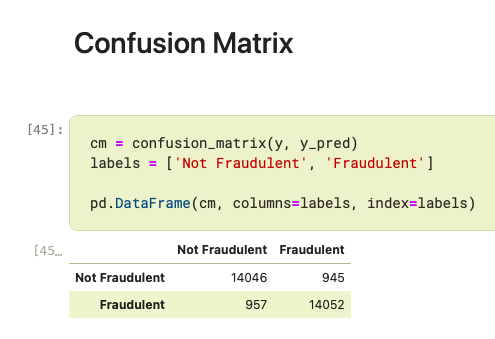

The confusion matrix above shows non-fraudulent and fraudulent transactiosn being classified correctly at a higher rate than they are classified wrongly. 

# Model Improvement

There are a few ways I can think of to improve this final model :

1. Improved feature selection using methods like correlation, feature importance, etc. to reduce features while improving performance 

2. Dimension reduction methods like PCA to reduce features while improving performance 

3. Use ensemble methods to improve model performance 
